In [3]:
import torch
from matplotlib.pyplot import xlabel, yscale, xscale
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random

In [8]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)

In [9]:
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

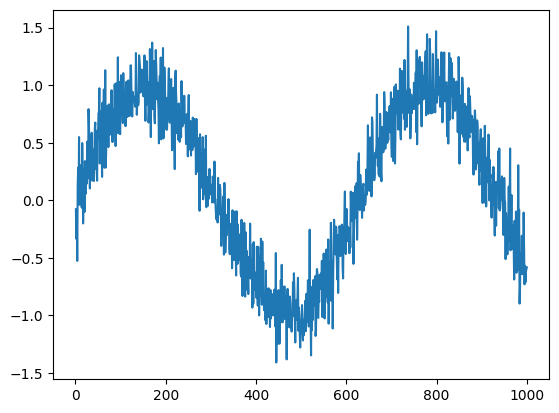

In [10]:
plt.plot(time, x)

In [11]:
tau=4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels=x[tau:].reshape(-1,1)


batch_size=16
n_train=600

In [12]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(4, 10)
            ,nn.ReLU()
            ,nn.Linear(10, 1))
        self.sequential.apply(init_weights)
    def forward(self,x):
        return self.sequential(x)

In [13]:
class TimeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data            # 数据路径或数据本身
        self.labels = labels         # 标签
        self.transform = transform  # 数据预处理（如transforms.Compose）

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [14]:
data=TimeDataset(features[:600], labels[:600])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
loss=nn.MSELoss(reduction='none')

In [15]:
def train(model, train_iter, loss, epoch, lr):
    trainer=torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch):
        for x,y in train_iter:
            trainer.zero_grad()
            y_hat=model(x)
            l=loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        
        loss_eval=0
        for x,y in train_iter:
            loss_eval+=loss(model(x), y).sum()
        
        print(f'epoch {epoch + 1}, '
              f'loss: {loss_eval})')
    

In [16]:
net=Net()

In [17]:
train(net,dataloader,loss,5,lr=0.01)

epoch 1, loss: 30.008996963500977)
epoch 2, loss: 29.969913482666016)
epoch 3, loss: 28.675823211669922)
epoch 4, loss: 27.659687042236328)
epoch 5, loss: 27.37936019897461)


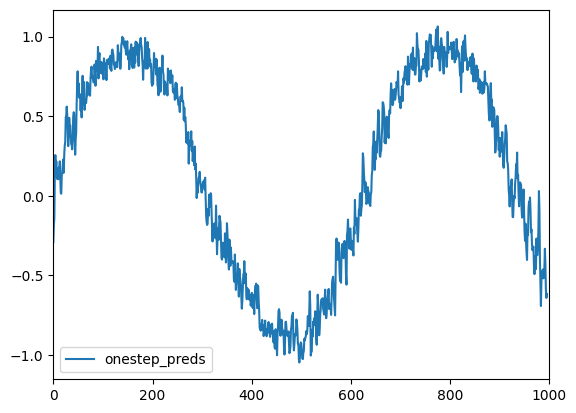

In [18]:
plt.plot(net(features).detach().numpy())
plt.legend(['onestep_preds'])
plt.xlim([0,1000])
plt.show()

In [19]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

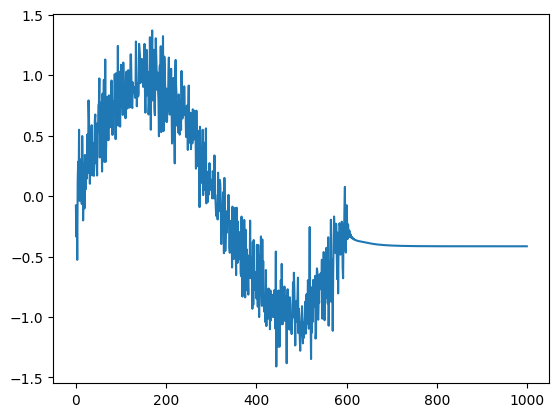

In [20]:
plt.plot(multistep_preds.detach().numpy())
##这个地方出错是正常的

In [21]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是第（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

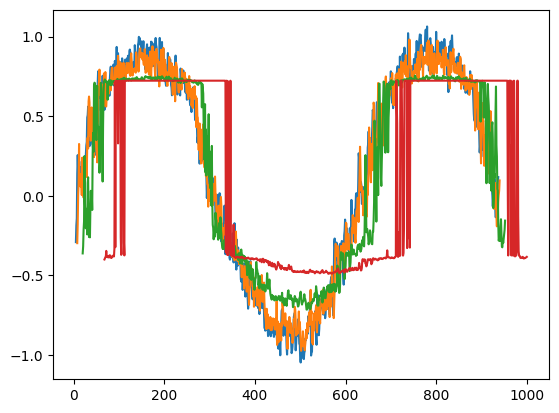

In [22]:
steps = (1, 4, 16, 64)
for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i].detach().numpy(),
             features[:, (tau + i - 1)].detach().numpy())

In [23]:
import collections
import re
import requests
import matplotlib.pyplot as plt
import random

# 循环神经网络

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import sys
sys.path.append('../')
from utils.useful_func import *

batch_size, num_steps = 32, 35
##train_iter 返回的是每个字母的索引
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [2]:
## 将每个索引映射为相互不同的单位向量
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

In [3]:
# 初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01
    ## 隐藏层参数
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)
    W_hq=normal((num_hiddens,num_outputs))
    b_q=torch.zeros(num_outputs,device=device)
    params=[W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [4]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size, num_hiddens),device=device),)

In [6]:
def rnn(inputs, state,params):
    [W_xh,W_hh,b_h,W_hq,b_q]=params
    H,=state
    outputs=[]
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
        # Y的形状是batch_size * input_size
    return torch.cat(outputs, dim=0),(H,)

In [7]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn
                 ):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, inputs, state):
        #转置的目的是 为了能够将x的时间步调整至外维 以直接遍历训练序列数据
        X = F.one_hot(inputs.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)


In [8]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    ##outputs只有第一个字母
    outputs = [vocab[prefix[0]]]
    ## 定义一个获取最新output的函数
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        ##get_input()每次只有一个值 作为输入 state为隐状态
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [10]:
net = RNNModelScratch(len(vocab), 512, 'cpu', get_params,init_rnn_state, rnn)

In [11]:
state = net.begin_state(X.shape[0], 'cpu')

In [12]:
Y, new_state = net(X, state)

In [13]:
#输出形状是（时间步数批量大小，词表大小）， 而隐状态形状保持不变，即（批量大小，隐藏单元数）。
Y.shape,new_state

(torch.Size([10, 28]),
 (tensor([[-0.0002,  0.0199, -0.0101,  ...,  0.0015,  0.0132, -0.0068],
          [ 0.0025,  0.0058, -0.0014,  ..., -0.0151,  0.0034,  0.0116]],
         grad_fn=<TanhBackward0>),))

In [14]:
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    norm=torch.sqrt(torch.sum(torch.tensor([torch.sum(p.grad**2) for p in params])))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent.

    Defined in :numref:`sec_utils`"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 初始化状态
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            # 非原地分离状态
            if isinstance(net, nn.Module):
                if isinstance(state, tuple):
                    # LSTM状态：分离每个张量
                    state = tuple(s.detach() for s in state)
                else:
                    # GRU状态：直接分离
                    state = state.detach()
            else:
                # 自定义模型状态处理
                state = (s.detach() for s in state)
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()

    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


In [16]:
num_epochs, lr = 10, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, 'cpu')


time traveller  the rith a dit the rith a dit the rith a dit the
困惑度 7.8, 54009.3 词元/秒 cpu
time traveller  the rith a dit the rith a dit the rith a dit the
traveller  the rith a dit the rith a dit the rith a dit the


In [56]:
predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, 'cpu')